## 1. Import and Define Modules

In [56]:
#Import Libraries
#Core Python, Pandas, and kaldi_io
import numpy as np
import pandas as pd
import string
import pickle
from collections import defaultdict, Counter
import random
import kaldi_io
import itertools

#Scikit
from sklearn import manifold
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances,average_precision_score
from sklearn.metrics.pairwise import pairwise_kernels
from scipy import stats
from scipy.spatial.distance import pdist
from scipy.stats import kurtosis, skew, binned_statistic
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance

#Plotting
from matplotlib import pyplot as plt
import seaborn as sns



#Torch and utilities
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset,DataLoader,random_split,ConcatDataset
import torch.cuda as cutorch

#Import User defined classes
from AweNoise.models.torch_models import SimpleNet, SimpleNet_with_dropout, SiameseNet
from AweNoise.torch_utils import evaluate_model,test_classifier, baseline, accuracy
from AweNoise.datasets import CNN_dataset, SiameseTriplets, Soe_dataset

#Align Sequences
import sfba4
from sfba4.utils import alignSequences
#from big_phoney import BigPhoney
from g2p_en import G2p
from arpabetandipaconvertor.arpabet2phoneticalphabet import ARPAbet2PhoneticAlphabetConvertor

In [2]:
# Phonologically-Weighted Levenstein Distance (PWLD)

def PWLD(s, t):
        ''' From Wikipedia article; Iterative with two matrix rows. '''
        if s == t: return 0
        elif len(s) == 0: return len(t)
        elif len(t) == 0: return len(s)
        v0 = [None] * (len(t) + 1)
        v1 = [None] * (len(t) + 1)
        for i in range(len(v0)):
            v0[i] = i
        for i in range(len(s)):
            v1[0] = i + 0.5
            for j in range(len(t)):
                cost = 0 if s[i] == t[j] else phone2dist[s[i]][t[j]]
                v1[j + 1] = min(v1[j] + 0.5, v0[j + 1] + 0.5, v0[j] + cost)
            for j in range(len(v0)):
                
                
                v0[j] = v1[j]
                
        return v1[len(t)]

In [3]:
def load_model(num_output):
    '''Function to create a model given number of outputs, and load weights'''
    
    #CNN
    net = SimpleNet(num_output)
    net = net.float()
    net.to(dev)
    
    model_save_path = "C:/Users/jayes/Downloads/LSV/Models/cnn_clean.pth"
    #Load model weights
    net.load_state_dict(torch.load(model_save_path))
    
    return net

In [4]:
def nearest_words_awe(embedding, num_neighbours = 12):
    '''Find the nearest clean embeddings of the given embedding and return the word label'''
    
    
    #Fetching n+1 nearest neighbour as the nearest one is the same word
    
    nearest_word_indices = neigh_awe.kneighbors(embedding, num_neighbours + 1, False)
    
    nearest_words = [soe_words[nearest_word_indices[0][i]] for i in range(1,nearest_word_indices.shape[1])]
    
    return nearest_words

In [5]:
def nearest_words_edit_distance(word, num_neighbours = 12):
    '''Find the nearest clean embeddings of the given embedding and return the word label'''
    
    #Calculate cosine distance between the embedding and all the clean embeddings
    #distances = pairwise_distances(embeddings, clean_awe_embeddings, metric = 'cosine')
    #labels = np.argmin(distances, axis = 1)
    
    
    
    word_index = np.array(soe_words.index(word)).reshape(-1,1)
    
    nearest_word_indices = neigh_edit.kneighbors( n_neighbors = num_neighbours, return_distance =  False)[word_index]
    nearest_word_indices = np.array(nearest_word_indices).squeeze().reshape(1,-1)
    
    #Ignoring the nearest word as it is the same word
    nearest_words = [soe_words[nearest_word_indices[0][i]] for i in range(nearest_word_indices.shape[1])]
    
    return nearest_words

In [6]:
def map_phoneme(phoneme):
    if phoneme == "g":
        return 'ɡ'
    elif phoneme == "ɝ":
        return 'ɚ'
    else:
        return phoneme

In [7]:
def filter_alphabets(string):
    #return string
    return ''.join(e for e in string if (e.isalpha() or e.isspace()))

In [8]:
def edit_distance(word_1,word_2):
    #aligned_seq1, aligned_seq2, eDistance = alignSequences.align(word_phoneme_dict[word_1], word_phoneme_dict[word_2])
    
    eDistance = PWLD(word_ipa_phoneme_dict[word_1], word_ipa_phoneme_dict[word_2])
    
    #error_rate = eDistance/len(word_phoneme_dict[word_1].split())
    return eDistance

## 2. Create and Save Embeddings

In [9]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [10]:
#Load the model
#Load Best Clean Model
num_output = 8607 #Num output is same as clean dataset
net = load_model(num_output)

In [11]:
#Load the slip of ear dataset
clean_ds = Soe_dataset(split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = np.Inf, k = np.Inf, cluster = False)
noisy_ds = Soe_dataset(split_set = "train", char_threshold = 5, frequency_bounds = (0,np.Inf), snr = -5, k = np.Inf, cluster = False)

#Dataloaders
bs = 64
clean_dl = DataLoader(clean_ds, batch_size=bs, pin_memory = True, shuffle = True, drop_last = False)
noisy_dl = DataLoader(noisy_ds, batch_size=bs, pin_memory = True, shuffle = True, drop_last = False)

Finished Loading the Data, 6944 examples
Number of Unique words  6944
Finished Loading the Data, 3200 examples
Number of Unique words  1729


In [12]:
test_dl = clean_dl

In [ ]:
#Create embeddings for slip of ear words
soe_embeddings_dict = {}
for xb,yb in test_dl:

        #Move to GPU
        xb,yb = xb.to(dev, non_blocking=True),yb.to(dev, non_blocking=True)
        y_embed = net.give_embeddings(xb, dev)
        

        for i in range(y_embed.shape[0]):
            word = clean_ds.num_to_word[yb[i].item()]
            
            soe_embeddings_dict[word] = y_embed[i]

#print(soe_embeddings_dict)

In [ ]:
#Save the embeddings for slip of ear words
filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_clean_embeddings.npy"
#filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_noisy_embeddings.npy"
np.save(filepath, soe_embeddings_dict)


## 3. Calculate Nearest Neighbours based on Embedding and Edit Distances

### 3.1 Calculate Phonetic Expansion of all words in the dictionary

In [43]:
#Load soe clean embeddings
clean_filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_clean_embeddings.npy"
soe_clean_embeddings_dict = np.load(clean_filepath, allow_pickle = True).item()

#Construct a list of word labels and their embeddings
soe_words = []
soe_clean_embeddings = []

for word, awe in soe_clean_embeddings_dict.items():
    soe_words.append(word)
    soe_clean_embeddings.append(awe.squeeze())

soe_clean_embeddings = np.stack(soe_clean_embeddings)

print(len(soe_words))
print(soe_clean_embeddings.shape)

6944
(6944, 8607)


In [14]:
#Create a BigPhoney Object
#phoney = BigPhoney()

#Create a g2p object
g2p = G2p()

In [15]:
#Create a word phoneme dict of soe_words
word_phoneme_dict = {}

for word in soe_words:
    #phonemes = phoney.phonize(word)
    phonemes = g2p(word)
    word_phoneme_dict[word] = " ".join(filter_alphabets(phoneme) for phoneme in phonemes)

print(word_phoneme_dict)

{'ceiling': 'S IY L IH NG', 'law': 'L AO', 'plateau': 'P L AE T OW', 'stench': 'S T EH N CH', 'gain': 'G EY N', 'spice': 'S P AY S', 'imprint': 'IH M P R IH N T', 'flippant': 'F L IH P AH N T', 'bland': 'B L AE N D', 'rubber': 'R AH B ER', 'self': 'S EH L F', 'stinky': 'S T IH NG K IY', 'taxi': 'T AE K S IY', 'illness': 'IH L N AH S', 'bed': 'B EH D', 'boneless': 'B OW N L AH S', 'invalid': 'IH N V AH L AH D', 'bake': 'B EY K', 'draw': 'D R AO', 'argon': 'AA R G AA N', 'received': 'R AH S IY V D', 'tool': 'T UW L', 'movement': 'M UW V M AH N T', 'versus': 'V ER S AH S', 'muddling': 'M AH D AH L IH NG', 'tighten': 'T AY T AH N', 'revere': 'R IH V IH R', 'group': 'G R UW P', 'carve': 'K AA R V', 'talked': 'T AO K T', 'skull': 'S K AH L', 'true': 'T R UW', 'pivot': 'P IH V AH T', 'petty': 'P EH T IY', 'produces': 'P R AH D UW S AH Z', 'filed': 'F AY L D', 'minute': 'M IH N AH T', 'jointly': 'JH OY N T L IY', 'warship': 'W AO R SH IH P', 'angling': 'AE NG G L IH NG', 'past': 'P AE S T', 'p

In [16]:
f = ARPAbet2PhoneticAlphabetConvertor()

In [17]:
#Transform phoneme expansion from two letter to single letter form
word_ipa_phoneme_dict = {}
for word, phonemes in word_phoneme_dict.items():
    word_ipa_phoneme_dict[word] = " ".join(map_phoneme(phoneme) for phoneme in f.convert_to_american_phonetic_alphabet(phonemes))
    
print(word_ipa_phoneme_dict)

{'ceiling': 's i l ɪ ŋ', 'law': 'l ɔ', 'plateau': 'p l æ t o', 'stench': 's t ɛ n t ʃ', 'gain': 'ɡ e n', 'spice': 's p a ɪ s', 'imprint': 'ɪ m p r ɪ n t', 'flippant': 'f l ɪ p ʌ n t', 'bland': 'b l æ n d', 'rubber': 'r ʌ b ɚ', 'self': 's ɛ l f', 'stinky': 's t ɪ ŋ k i', 'taxi': 't æ k s i', 'illness': 'ɪ l n ʌ s', 'bed': 'b ɛ d', 'boneless': 'b o n l ʌ s', 'invalid': 'ɪ n v ʌ l ʌ d', 'bake': 'b e k', 'draw': 'd r ɔ', 'argon': 'ɑ r ɡ ɑ n', 'received': 'r ʌ s i v d', 'tool': 't u l', 'movement': 'm u v m ʌ n t', 'versus': 'v ɚ s ʌ s', 'muddling': 'm ʌ d ʌ l ɪ ŋ', 'tighten': 't a ɪ t ʌ n', 'revere': 'r ɪ v ɪ r', 'group': 'ɡ r u p', 'carve': 'k ɑ r v', 'talked': 't ɔ k t', 'skull': 's k ʌ l', 'true': 't r u', 'pivot': 'p ɪ v ʌ t', 'petty': 'p ɛ t i', 'produces': 'p r ʌ d u s ʌ z', 'filed': 'f a ɪ l d', 'minute': 'm ɪ n ʌ t', 'jointly': 'd ʒ ɔ ɪ n t l i', 'warship': 'w ɔ r ʃ ɪ p', 'angling': 'æ ŋ ɡ l ɪ ŋ', 'past': 'p æ s t', 'pastime': 'p æ s t a ɪ m', 'rotten': 'r ɑ t ʌ n', 'latent': 'l e 

In [18]:
phoneme_set = set([ipa for ipa_letters in word_ipa_phoneme_dict.values() for ipa in ipa_letters.split()])
print(phoneme_set)

{'ŋ', 'ɚ', 'p', 'l', 'ɔ', 'm', 'ʒ', 'ʃ', 'd', 'w', 's', 'ɛ', 'a', 'ʌ', 'ð', 'ʊ', 'b', 'o', 'ɑ', 'j', 'h', 'r', 'ɪ', 'v', 'æ', 'e', 'ɡ', 'k', 'f', 'θ', 't', 'z', 'i', 'u', 'n'}


In [19]:
print(word_ipa_phoneme_dict["sleek"])
print(word_ipa_phoneme_dict["difficult"])

s l i k
d ɪ f ʌ k ʌ l t


In [120]:
print(edit_distance("sleek", "worthless"))
print(edit_distance("sleek", "slack"))
print(edit_distance("sleek", "sleep"))
print(edit_distance("sleek", "sleepy"))

2.473684210526316
0.07894736842105263
0.21052631578947367
1.0


In [121]:
word_1, word_2 = "sleek","worthless"
word_index_1 = np.array(soe_words.index(word_1)).reshape(-1,1)[0][0]
word_index_2 = np.array(soe_words.index(word_2)).reshape(-1,1)[0][0]
print(word_index_1, word_index_2)
print(soe_edit_distance_matrix[word_index_1][word_index_2])

4648 83
2.0


In [42]:
soe_edit_distance_matrix.shape

(6944, 6944)

### 3.2 Create a distance matrices

In [21]:
#Distance matrix for phonemes

#Load Phoneme2Vec
with open("C:/Users/jayes/Downloads/LSV/Data/feature_dict.p", "rb") as input_file:
    phone2vec = pickle.load(input_file)


#Create Phoneme Distance matrix
phone2dist = defaultdict(lambda: defaultdict(float))

for p1 in phoneme_set:
    for p2 in phoneme_set:
        
        dist = distance.hamming(phone2vec[p1], phone2vec[p2])#**(1/2)

        phone2dist[p1][p2] = dist

In [22]:
#Distance matrix for phonemic expansion of words

soe_edit_distance_matrix = np.zeros((len(soe_words),len(soe_words)))

for i,word_1 in enumerate(soe_words):
    for j,word_2 in enumerate(soe_words):
        if i>= j:
            continue
        soe_edit_distance_matrix[i,j] = edit_distance(word_1, word_2)
        soe_edit_distance_matrix[j,i] = soe_edit_distance_matrix[i,j]
    print(i)
    
#Copy lower triangle to upper triangle
#il1 = np.tril_indices(len(soe_words),-1)
#iu1 = np.triu_indices(len(soe_words), 1)
#soe_edit_distance_matrix[il1] = soe_edit_distance_matrix[iu1] 


filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_edit_distance_matrix.npy"
np.save(filepath, soe_edit_distance_matrix)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340


6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943


In [23]:
filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_edit_distance_matrix.npy"
soe_edit_distance_matrix = np.load(filepath)

In [24]:
#Construct Nearest Neighbour objects for querying nearest neighbours according to awe and edit distance respectively

#nn according to awe
neigh_awe = NearestNeighbors( metric = 'cosine', n_neighbors = 13, n_jobs = -1)
neigh_awe.fit(soe_clean_embeddings)

#nn according to edit distance
neigh_edit = NearestNeighbors( metric = 'precomputed', n_neighbors = 12, n_jobs = -1)
neigh_edit.fit(soe_edit_distance_matrix)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='precomputed',
                 metric_params=None, n_jobs=-1, n_neighbors=12, p=2,
                 radius=1.0)

### 3.2 Determine the closest words according to embedding and PWDL distance

In [25]:
#Look at neighbourhood of the words and determine the top 11 nearest words
soe_nn_awe = {}
soe_nn_edit = {}
for i, (word,awe) in enumerate(soe_clean_embeddings_dict.items()):
    soe_nn_awe[word] = nearest_words_awe(awe.reshape(1,-1))
    soe_nn_edit[word] = nearest_words_edit_distance(word)
    if ((i+1) % 100 == 0):
        print(i+1)
        
    

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900


In [26]:
print(soe_nn_awe)

{'ceiling': ['saying', 'cleaning', 'feign', 'saloon', 'swimming', 'swinging', 'swing', 'swoon', 'chain', 'feeling', 'fume', 'sailing'], 'law': ['adore', 'blown', 'converge', 'girl', 'ling', 'clan', 'obliged', 'grapple', 'prow', 'purple', 'plunge', 'ample'], 'plateau': ['hippo', 'photo', 'flicker', 'sweater', 'twitter', 'symptom', 'disheartened', 'contract', 'spur', 'stripper', 'agile', 'closer'], 'stench': ['scent', 'presents', 'thank', 'sent', 'defence', 'strength', 'cent', 'offence', 'deference', 'decree', 'theory', 'ferment'], 'gain': ['vein', 'bane', 'deign', 'lane', 'vain', 'wane', 'novel', 'mane', 'name', 'main', 'blame', 'lean'], 'spice': ['bike', 'bite', 'work', 'worker', 'quite', 'white', 'widespread', 'bark', 'west', 'mite', 'eyes', 'mike'], 'imprint': ['ferment', 'hope', 'devote', 'different', 'temperance', 'decree', 'degree', 'cent', 'offence', 'percent', 'defence', 'clothed'], 'flippant': ['ferment', 'hope', 'devote', 'temperance', 'decree', 'different', 'degree', 'cent', 

In [27]:
print(soe_nn_edit)

{'ceiling': ['sailing', 'shilling', 'searing', 'dealing', 'telling', 'seating', 'sharing', 'healing', 'railing', 'sitting', 'feeling', 'teasing'], 'law': ['lo', 'low', 'loo', 'row', 'know', 'no', 'lay', 'thaw', 'knew', 'doe', 'dough', 'saw'], 'plateau': ['platter', 'pretty', 'plater', 'plotter', 'bladder', 'flatter', 'bleeder', 'pleaser', 'prairie', 'clatter', 'pleasure', 'classy'], 'stench': ['staunch', 'starch', 'drench', 'change', 'fringe', 'chests', 'friends', 'clench', 'charge', 'brunch', 'scorch', 'stamps'], 'gain': ['cane', 'ken', 'keen', 'can', 'kin', 'gun', 'gate', 'gaol', 'gait', 'gale', 'keyed', 'get'], 'spice': ['spite', 'spied', 'spire', 'spine', 'skies', 'smile', 'spoil', 'stein', 'style', 'snide', 'stout', 'twice'], 'imprint': ['interest', 'instant', 'inflict', 'enchant', 'inbuilt', 'instilled', 'extent', 'extend', 'ingest', 'engraved', 'enclosed', 'encroach'], 'flippant': ['prevent', 'blatant', 'prepared', 'pleasant', 'clement', 'present', 'pretence', 'tripled', 'preten

In [28]:
for i, (word, item) in enumerate(soe_exp_nn.items()):
    print(word)
    print("Mishearings", item)
    print("Embedding Neighbours",soe_nn_awe[word])
    print("Phonetic Neighbours",soe_nn_edit[word])
    print("\n")
    if i == 2:
        break

NameError: name 'soe_exp_nn' is not defined

In [29]:
#Save the nearest neighbours of words
soe_nn_awe_filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_clean_nn_awe.npy"
soe_nn_edit_filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_clean_nn_edit.npy"

np.save(soe_nn_awe_filepath, soe_nn_awe)
np.save(soe_nn_edit_filepath, soe_nn_edit)

## Load the Slip of Ear Dataset and Compare Metrics

In [30]:
#Load the nearest neighbours of words
soe_nn_awe_filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_clean_nn_awe.npy"
soe_nn_edit_filepath = "C:/Users/jayes/Downloads/LSV/Data/soe_clean_nn_edit.npy"
soe_nn_awe = np.load(soe_nn_awe_filepath, allow_pickle = True).item()
soe_nn_edit = np.load(soe_nn_edit_filepath, allow_pickle = True).item()

In [31]:
#Load the slip of ear dataset and create a list of words and their mishearings
soe_filepath = "C:/Users/jayes/Downloads/LSV/Data/slip_of_ear.csv"
slip_df = pd.read_csv(soe_filepath)
slip_df.head()

,ID,Length,Masker,Onset,SNR,Speaker,Target,Raw,Responses,N-Listeners,Counts,Confusion,Consistency,Target-Arpabet,Target-IPA,Target-frequency,Confusion-Arpabet,Confusion-IPA,Confusion-frequency,Phoneme-distance
0,3784,11520,SSN,104656,-6.982,s3,jointly,drink|drink|drink|drinking|dream|jointly|join|...,drink|jointly|join|enjoyment|drinking|dream,15,9 2 1 1 1 1,drink,9,JH OY N T L IY,dʒ ɔɪ n t l i,3.10,D R IH NG K,d ɹ ɪ ŋ k,5.06,57.0
1,3786,9172,SSN,455143,-6.173,s3,buyer,fire|buyer|fire|fire|pie|fire|fire|quiet|fire|...,fire|buyer|quiet|pie|prior|final,15,9 2 1 1 1 1,fire,9,B AY AX,b aɪ ə,4.13,F AY AX,f aɪ ə,5.18,10.0
2,3787,13280,SSN,658770,-6.200,s3,sleek,sleek|sleep|sleep|sleek|sleep|sleek|sleep|slee...,sleep|sleek,15,10 5,sleep,10,S L IY K,s l i k,3.29,S L IY P,s l i p,4.94,10.0
3,3791,14898,SSN,826266,-5.132,s3,perverse,perverse|averse|traverse|reverse|reverse|perve...,reverse|perverse|averse|traverse,15,8 3 3 1,reverse,8,P AX V ER S,p ə v ɜː s,3.13,R IH V ER S,ɹ ɪ v ɜː s,4.15,20.0
4,3804,11876,SSN,496159,-5.623,s3,because,curse|because|coat|coast|reverse|coast|coast|c...,coast|coat|because|curse|reverse,15,8 2 2 2 1,coast,8,B IH K OH Z,b ɪ k ɒ z,6.22,K OW S T,k oʊ s t,4.86,41.0


In [152]:
slip_df = slip_df.sort_values('SNR')
slip_df.head()

,ID,Length,Masker,Onset,SNR,Speaker,Target,Raw,Responses,N-Listeners,Counts,Confusion,Consistency,Target-Arpabet,Target-IPA,Target-frequency,Confusion-Arpabet,Confusion-IPA,Confusion-frequency,Phoneme-distance
1937,27807,10560,SSN,332099,-6.999,s4,folk,ghost|coat|coke|coat|poke|coat|coke|goat|cope|...,coat|coke|ghost|poke|cope|cloak|goat,15,6 4 1 1 1 1 1,coat,6,F OW K,f oʊ k,4.24,K OW T,k oʊ t,2.74,20.0
1022,16276,11394,SSN,524225,-6.995,s3,clatter,platter|battle|platter|platter|platter|flatter...,platter|clatter|battle|plater|flatter,16,10 3 1 1 1,platter,10,K L AE T AX,k l æ t ə,3.31,P L AE T AX,p l æ t ə,3.28,10.0
2315,32520,10992,SSN,410269,-6.991,s2,hamlet,camera|hamlet|camera|hamlet|camera|asthmatic|h...,camera|hamlet|cameras|came|asthmatic,15,9 3 1 1 1,camera,9,HH AE M L AH T,h æ m l ə t,3.80,K AE M ER AH,k æ m ɜː ə,4.83,27.0
1858,26913,11680,SSN,355775,-6.986,s1,lust,lost|lust|lost|lost|lust|lost|lust|lust|next|l...,lost|lust|lots|next,15,7 6 1 1,lost,7,L AH S T,l ə s t,3.38,L AO S T,l ɔ s t,4.67,10.0
828,13727,12960,SSN,508697,-6.983,s1,surely,sure|shore|sure|short|sure|surely|draw|obscure...,sure|shrug|troll|draw|short|drug|shore|surely|...,14,6 1 1 1 1 1 1 1 1,sure,6,SH UA L IY,ʃ ʊə̯ l i,4.76,SH UA,ʃ ʊə̯,5.80,14.0


In [143]:
slip_df[slip_df['Target'] == "sleek"]

,ID,Length,Masker,Onset,SNR,Speaker,Target,Raw,Responses,N-Listeners,Counts,Confusion,Consistency,Target-Arpabet,Target-IPA,Target-frequency,Confusion-Arpabet,Confusion-IPA,Confusion-frequency,Phoneme-distance
2,3787,13280,SSN,658770,-6.200,s3,sleek,sleek|sleep|sleep|sleek|sleep|sleek|sleep|slee...,sleep|sleek,15,10 5,sleep,10,S L IY K,s l i k,3.29,S L IY P,s l i p,4.94,10.0
365,7823,11520,SSN,721772,-5.754,s4,sleek,sleep|see|sweet|sleep|estate|sleep|sleep|see|s...,see|sleep|sweet|scene|estate,15,7 5 1 1 1,see,7,S L IY K,s l i k,3.29,S IY,s i,4.59,14.0
2175,30734,13280,SSN,611537,-6.707,s3,sleek,sleek|sleep|sleep|sleep|sleep|sleep|sleep|slee...,sleep|sleek|sleepy,14,11 2 1,sleep,11,S L IY K,s l i k,3.29,S L IY P,s l i p,4.94,10.0


In [153]:
soe_exp_nn = {}
soe_word_snrs = {}
#Filter confusions for only SSN noise type
slip_df = slip_df[slip_df["Masker"] == "SSN"]

for id,row in slip_df.iterrows():
    #print(row.Target)
    #print(row.Responses.split('|'))
    #soe_exp_nn[row.Target] = row.Responses.split('|')
    if row.Target not in soe_exp_nn.keys():
        soe_exp_nn[row.Target] = [row.Confusion]
    else:
        soe_exp_nn[row.Target].append(row.Confusion)
        
    #soe_exp_nn[row.Target] = row.Confusion
    soe_word_snrs[row.Target] = row.SNR

for word in soe_exp_nn.keys():
    soe_exp_nn[word] = list(set(soe_exp_nn[word]))

In [141]:
print(soe_word_snrs)

{'jointly': -6.982, 'buyer': -5.777, 'sleek': -6.707000000000001, 'perverse': -4.538, 'because': -5.622999999999999, 'remote': -6.534, 'fit': -5.665, 'fairy': -4.112, 'brand': -5.32, 'junk': -5.376, 'pushed': -5.681, 'era': -6.7989999999999995, 'tact': -6.039, 'chess': -4.435, 'why': -4.247, 'pine': -5.581, 'gene': -6.789, 'reading': -6.056, 'moonlight': -4.2139999999999995, 'cloth': -5.6370000000000005, 'wooden': -4.438, 'fighting': -6.43, 'killer': -4.658, 'lousy': -6.789, 'joy': -4.266, 'calmly': -4.038, 'what': -6.263999999999999, 'tiles': -4.723, 'bite': -6.506, 'fraud': -5.912000000000001, 'earn': -6.455, 'turf': -4.7010000000000005, 'wife': -4.447, 'seldom': -6.635, 'autumn': -6.371, 'round': -6.282, 'ration': -4.353, 'sloppy': -4.9239999999999995, 'stove': -4.064, 'expert': -6.875, 'gaze': -6.343, 'porter': -5.398, 'daughter': -4.229, 'bare': -5.404, 'toll': -5.797000000000001, 'loss': -6.154, 'arid': -6.577000000000001, 'start': -5.23, 'prepared': -6.468999999999999, 'clad': -

In [148]:
print(soe_exp_nn)

{'jointly': ['drink'], 'buyer': ['quiet', 'fire'], 'sleek': ['see', 'sleep'], 'perverse': ['reverse'], 'because': ['coast'], 'remote': ['remember'], 'fit': ['bit'], 'fairy': ['there', 'then'], 'brand': ['friend'], 'junk': ['jump'], 'pushed': ['put', 'push'], 'era': ['mirror', 'hero'], 'tact': ['attack'], 'chess': ['chest'], 'why': ['wine'], 'pine': ['find'], 'gene': ['jewel'], 'reading': ['window'], 'moonlight': ['movement'], 'cloth': ['plot'], 'wooden': ['wood'], 'fighting': ['fighter'], 'killer': ['cure', 'pillar'], 'lousy': ['mound'], 'joy': ['join'], 'calmly': ['calm'], 'what': ['box'], 'tiles': ['time'], 'bite': ['fight'], 'fraud': ['broad'], 'earn': ['earth'], 'turf': ['turn'], 'wife': ['white'], 'seldom': ['self'], 'autumn': ['water'], 'round': ['rail', 'ground', 'brown'], 'ration': ['rushing'], 'sloppy': ['swapping'], 'stove': ['slow', 'stone'], 'expert': ['extra'], 'gaze': ['games'], 'porter': ['water'], 'daughter': ['water'], 'bare': ['there'], 'toll': ['cold', 'tall'], 'loss

In [34]:
soe_exp_words = set(soe_exp_nn.keys())

Average Precision using AWE  0.061962445797032265
Average Precision using Edit Distance  0.06268896447467875
Average Precision using Random Picking  0.0004574929386959462


Text(0.5, 0.98, 'Average Precision vs SNR (Binned)')

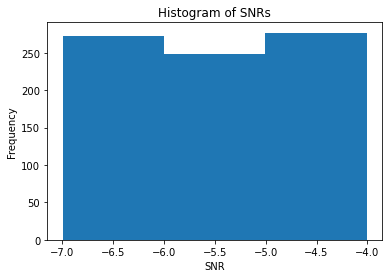

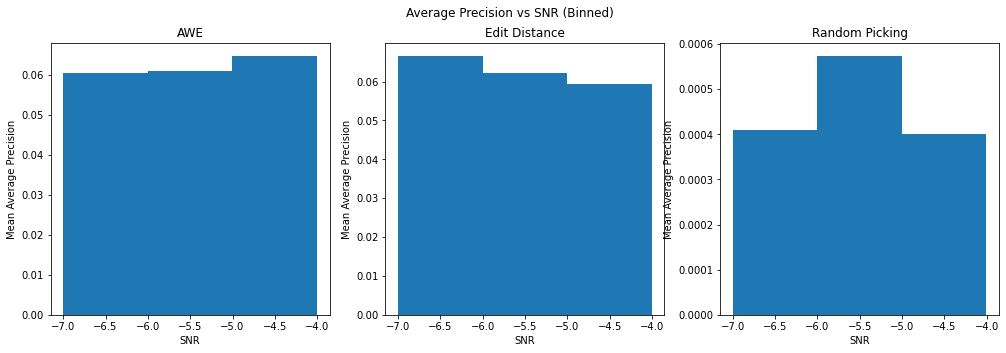

In [126]:
snrs = []
awe_precisions = []
edit_precisions = []
random_precisions = []
#recalls = []

for word, exp_response in soe_exp_nn.items():
    
    #Calculate precision recall for awe nearest neighbours 
    precision = len(set(exp_response).intersection(set(soe_nn_awe[word][:len(exp_response)])))/len(set(soe_nn_awe[word][:len(exp_response)]))
    recall = len(set(exp_response).intersection(set(soe_nn_awe[word][:len(exp_response)])))/len(set(exp_response))
    awe_precisions.append(precision)
    #recalls.append(recall)
    
    #Calculate precision recall for edit distance nearest neighbours 
    precision = len(set(exp_response).intersection(set(soe_nn_edit[word][:len(exp_response)])))/len(set(soe_nn_edit[word][:len(exp_response)]))
    recall = len(set(exp_response).intersection(set(soe_nn_edit[word][:len(exp_response)])))/len(set(exp_response))
    edit_precisions.append(precision)
    
    #Calculate precision recall for random neighbours 
    random_neighbours = random.sample(set(soe_words), len(exp_response))
    precision = len(set(exp_response).intersection(set(random_neighbours)))/len(set(random_neighbours))
    recall = len(set(exp_response).intersection(set(random_neighbours)))/len(set(exp_response))
    random_precisions.append(precision)
    
    #record snr of the word
    snrs.append(soe_word_snrs[word])
    
    
print("Average Precision using AWE ",np.mean(awe_precisions))
print("Average Precision using Edit Distance ",np.mean(edit_precisions))
print("Average Precision using Random Picking ",np.mean(random_precisions))
#print(np.mean(recalls))

#Histogram of SNRs
plt.hist(snrs, bins =3)
plt.title("Histogram of SNRs")
plt.xlabel("SNR")
plt.ylabel("Frequency")

#Binned precision according to snrs

#Number of bins
num_bins = 3


binned_abs_error = {}
edges = {}
bin_width = {}

#Get binned avg_p for AWE
binned_abs_error['awe'], edges['awe'], binned_number = binned_statistic(snrs,awe_precisions, 'mean', bins=num_bins)
#binned_std_error, edges,binned_number = binned_statistic(snrs,awe_precisions, 'std', bins=num_bins)
bin_width['awe'] = edges['awe'][1] - edges['awe'][0]

#Get binned avg_p for Edit Distance
binned_abs_error['edit'], edges['edit'], binned_number = binned_statistic(snrs, edit_precisions, 'mean', bins=num_bins)
#binned_std_error, edges,binned_number = binned_statistic(snrs, edit_precisions, 'std', bins=num_bins)
bin_width['edit'] = edges['edit'][1] - edges['edit'][0]

#Get binned avg_p for Random Precision
binned_abs_error['random'], edges['random'], binned_number = binned_statistic(snrs, random_precisions, 'mean', bins=num_bins)
#binned_std_error, edges,binned_number = binned_statistic(snrs, random_precisions, 'std', bins=num_bins)
bin_width['random'] = edges['random'][1] - edges['random'][0]

#Plot the binned Stats

fig, axs = plt.subplots(1,3, figsize = (17,5))

axs[0].bar(edges['awe'][:-1],binned_abs_error['awe'],bin_width['awe'], align = 'edge')
axs[1].bar(edges['edit'][:-1],binned_abs_error['edit'],bin_width['edit'], align = 'edge')
axs[2].bar(edges['random'][:-1],binned_abs_error['random'],bin_width['random'], align = 'edge')

types = ['AWE','Edit Distance','Random Picking']
for i in range(3):
    axs[i].set_ylabel('Mean Average Precision')
    axs[i].set_xlabel('SNR')
    axs[i].set_title(types[i])
fig.suptitle("Average Precision vs SNR (Binned)")

In [158]:
awe_precisions = []
edit_precisions = []
random_precisions = []
#recalls = []

for i, (word, exp_response) in enumerate(soe_exp_nn.items()):
    print(word)
    for confusion in exp_response:
        #Calculate precision recall for awe nearest neighbours 
        precision = len(set([confusion]).intersection(set(soe_nn_awe[word])))
        #print(word)
        #print(exp_response)
        #print(soe_nn_awe[word])
        #print(precision)
        awe_precisions.append(precision)
        #recalls.append(recall)
        #print("\n")

        #Calculate precision recall for edit distance nearest neighbours 
        precision = len(set([confusion]).intersection(set(soe_nn_edit[word])))
        edit_precisions.append(precision)

        #print(word)
        #print(exp_response)
        #print(soe_nn_edit[word])
        #print(precision)
        #print("\n")


        #Calculate precision recall for random neighbours 
        random_neighbours = random.sample(soe_words, len(exp_response))
        precision = len(set([confusion]).intersection(set(random_neighbours)))
        random_precisions.append(precision)

    
print("Average Precision using AWE ",np.mean(awe_precisions))
print("Average Precision using Edit Distance ",np.mean(edit_precisions))
print("Average Precision using Random Picking ",np.mean(random_precisions))
#print(np.mean(recalls))

print(awe_precisions)

folk
clatter
hamlet
lust
surely
jointly
casting
tiny
thief
darkness
bazaar
throat
shame
chalk
save
vile
aloud
riot
asleep
childhood
law
none
favoured
forest
skilled
plight
day
circuit
dawn
oak
flame
at
width
solve
sorry
slab
boot
leisure
facade
sturdy
obey
namely
package
otter
jug
prove
sherry
graceful
sparkling
amount
expert
nightmare
biting
unused
share
settled
sheet
fairness
travelling
sly
scarf
stride
doubly
method
airport
banner
tummy
regard
decide
clinic
palm
spread
parade
marry
squadron
standard
midwife
leather
likely
tidal
era
active
splendour
lousy
gene
parting
twelfth
shock
woodland
shall
wax
manly
neat
drought
veil
sung
motive
keeping
bin
grandson
wisely
sleek
broken
verse
home
mug
scene
placed
wash
arrest
apt
oneself
shortly
card
cheek
give
flap
taking
shark
lounge
ashamed
widely
asset
seldom
midday
nets
hide
pad
freezing
same
after
blackboard
sandy
hand
bath
himself
lord
grand
shiny
button
discuss
arid
fuss
ought
rhythm
lap
firmly
trying
column
horrid
traveller
sitting
cha